<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

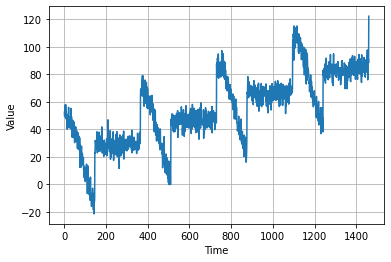

In [2]:
# Set the dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)

In [0]:
# Split dataset into training and validation sets
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the single LSTM model
model = tf.keras.models.Sequential([
  # Expand 1 dimentional data to RNN input data size (batch size, #time steps, #dim)
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # Defaul activation function in the RNN layer is tanh and output values between -1 to 1
  # so, x scal up to multiply by 100 and speed up learning
  tf.keras.layers.Lambda(lambda x: x * 100.0)   
])

# Set the learning rate by callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(), # Huber loss: less sensitive to outliers
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 41.9758 - mae: 42.4753 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 41.8121 - mae: 42.3117 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 41.5491 - mae: 42.0489 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 41.2183 - mae: 41.7182 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 40.8304 - mae: 41.3304 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 40.3834 - mae: 40.8833 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 39.8791 - mae: 40.3789 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 39.3022 - mae: 39.8019 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 38.6430 - mae: 39.1425 - lr: 2.5119e-08


(1e-08, 0.0001, 0.0, 30.0)

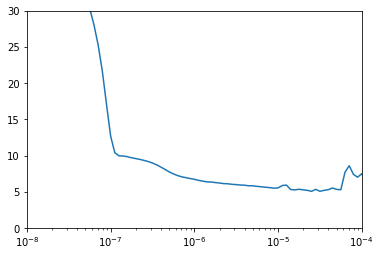

In [6]:
# Plot the loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Stable point -- 3e-5

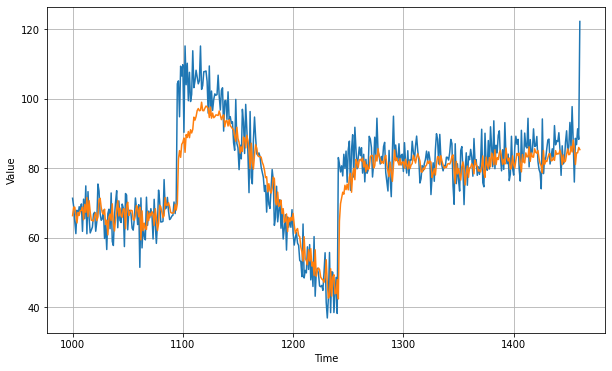

In [0]:
# Plot results
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.474565

In [0]:
# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the 2 layer of LSTM model
model = tf.keras.models.Sequential([
  # Expand 1 dimentional data to RNN input data size (batch size, #time steps, #dim)
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # Defaul activation function in the RNN layer is tanh and output values between -1 to 1
  # so, x scal up to multiply by 100 and speed up learning
  tf.keras.layers.Lambda(lambda x: x * 100.0)   
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1
)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 20.6069 - mae: 21.0998
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 17.0077 - mae: 17.5018
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 15.1220 - mae: 15.6166
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 14.3675 - mae: 14.8615
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 13.9184 - mae: 14.4083
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 13.4826 - mae: 13.9747
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 13.0717 - mae: 13.5630
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 12.6261 - mae: 13.1191
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 12.2132 - mae: 12.7058
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 11.9076 - mae: 12.3989
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

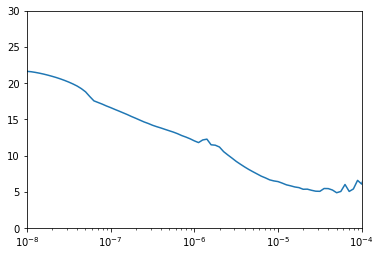

In [0]:
# Plot the loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Stable point -- 3e-5

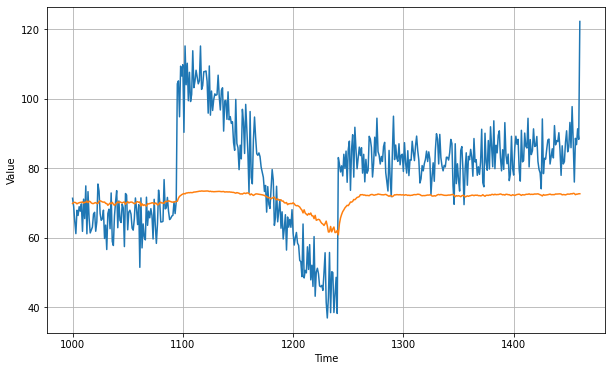

In [0]:
# Plot results
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

12.275518

In [0]:
# Clear any internal variables to make easy to experiment w/o models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Create the dataset
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Buld the 3 layer of LSTM model
model = tf.keras.models.Sequential([
  # Expand 1 dimentional data to RNN input data size (batch size, #time steps, #dim)
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # Defaul activation function in the RNN layer is tanh and output values between -1 to 1
  # so, x scal up to multiply by 100 and speed up learning
  tf.keras.layers.Lambda(lambda x: x * 100.0)   
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mse"]
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1
)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 942.7821 - mse: 942.7821
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 603.2019 - mse: 603.2019
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 271.3737 - mse: 271.3737
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 212.0160 - mse: 212.0160
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 157.5889 - mse: 157.5889
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 123.6470 - mse: 123.6470
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 107.6110 - mse: 107.6110
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 92.4264 - mse: 92.4264
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 87.7906 - mse: 87.7906
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 82.7912 - mse: 82.7912
Epoch 11/100
8/8 [=================

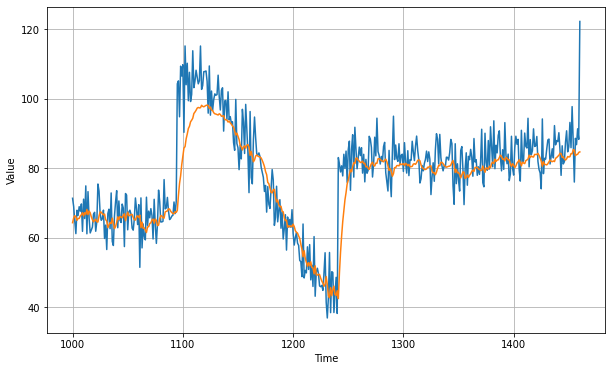

In [0]:
# Plot results
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.463876

<Figure size 432x288 with 0 Axes>

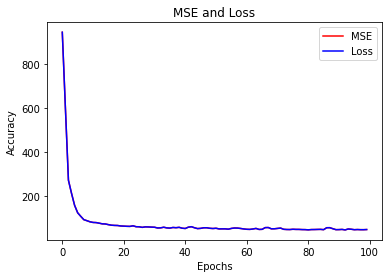

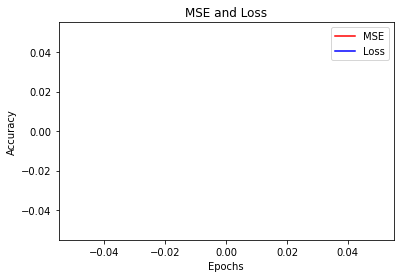

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()